# CEO-REQUEST CHALLENGE

Based on the kaggle dataset of the brazilian online market place Olist at: https://www.kaggle.com/olistbr/brazilian-ecommerce

We want to use this dataset to do some data analysis regarding the profitability of the sellers Olist allows to use their platform. For that analysis we use some basic assumptions:

**Revenue**

- Olist takes a 10% cut on the product price (excl. freight) of each order delivered.
- Olist charges 80 BRL by month per seller.

**Cost**

In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:

- a review score of 1 star costs 100 BRL
- a review score of 2 stars costs 50 BRL
- a review score of 3 stars costs 40 BRL
- review scores of 4 or 5 stars aren't associated with additional costs

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).
For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.
The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

Therefore the question we want to answer in the end is:

> **Should Olist remove underperforming sellers from its marketplace?**

To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step 1: Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step 2: We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin.

## Analysis of the profitablity for each seller

### Imports and Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
from olist.seller import Seller
data = Seller().get_training_data()
data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,1.514329,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.155190,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025000,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000000,167.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.000000,1.000000,5.00,2,2,1.000000,158.00
2966,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.561781,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,0.100000,0.500000,4.10,10,10,1.000000,889.00
2967,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,0.000000,1.000000,5.00,6,7,1.166667,550.04
2968,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,0.000000,0.500000,4.25,8,11,1.375000,297.00


### Revenue per seller

In [4]:
columns = ['seller_id', 'date_first_sale', 'date_last_sale', 'sales']
revenue = data[columns].copy()
revenue.head()

,seller_id,date_first_sale,date_last_sale,sales
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99


#### How long is the Seller using Olist? (active time)

In [5]:
revenue['active_time'] = np.ceil((revenue.date_last_sale -
                      revenue.date_first_sale) / np.timedelta64(1, 'M'))
revenue

,seller_id,date_first_sale,date_last_sale,sales,active_time
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,4.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,15.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.0
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.0
...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,2018-07-14 03:10:19,2018-07-23 15:34:03,158.00,1.0
2966,f8201cab383e484733266d1906e2fdfa,2017-06-17 15:30:11,2018-08-11 19:55:17,889.00,14.0
2967,74871d19219c7d518d0090283e03c137,2018-04-05 17:09:46,2018-08-21 19:25:15,550.04,5.0
2968,e603cf3fec55f8697c9059638d6c8eb5,2017-02-09 02:43:17,2017-06-16 17:30:16,297.00,5.0


#### How much revenue is created by monthly fees of 80 BRL/month?

In [6]:
revenue['monthly_fees'] = revenue.active_time * 80
revenue.head()

,seller_id,date_first_sale,date_last_sale,sales,active_time,monthly_fees
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,4.0,320.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,15.0,1200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.0,0.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.0,0.0
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.0,0.0


#### How much revenue is created by the 10% cut on the sales?

In [7]:
revenue['ten_percent_cut'] = round(revenue.sales * 0.1, 2)
revenue.head()

,seller_id,date_first_sale,date_last_sale,sales,active_time,monthly_fees,ten_percent_cut
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,4.0,320.0,21.87
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,15.0,1200.0,1170.31
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.0,0.0,15.80
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.0,0.0,8.00
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.0,0.0,16.80


#### What is the total revenue?

In [8]:
revenue['total_revenue'] = round(revenue.monthly_fees + revenue.ten_percent_cut, 2)
revenue.head()

,seller_id,date_first_sale,date_last_sale,sales,active_time,monthly_fees,ten_percent_cut,total_revenue
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,4.0,320.0,21.87,341.87
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,15.0,1200.0,1170.31,2370.31
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.0,0.0,15.80,15.80
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.0,0.0,8.00,8.00
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.0,0.0,16.80,16.80


(0.0, 5000.0)

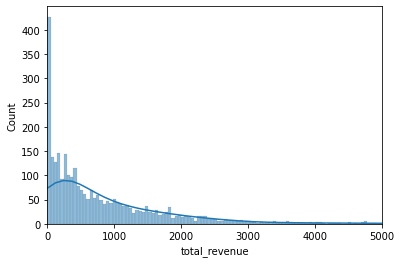

In [9]:
sns.histplot(revenue['total_revenue'], bins= 500, kde= True)
plt.xlim(0,5000)

### Cost due to bad reviews

#### Average cost for share of 1 star reviews

In [10]:
columns = ['seller_id', 'share_of_one_stars', 'n_orders']
review_cost = data[columns].copy()
review_cost.head()

,seller_id,share_of_one_stars,n_orders
0,3442f8959a84dea7ee197c632cb2df15,0.333333,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,0.050000,40
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.000000,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.000000,1
4,51a04a8a6bdcb23deccc82b0b80742cf,1.000000,1


In [11]:
review_cost['avg_one_star_cost'] = review_cost.n_orders * review_cost.share_of_one_stars *100
review_cost.head()

,seller_id,share_of_one_stars,n_orders,avg_one_star_cost
0,3442f8959a84dea7ee197c632cb2df15,0.333333,3,100.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,0.050000,40,200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.000000,1,0.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.000000,1,0.0
4,51a04a8a6bdcb23deccc82b0b80742cf,1.000000,1,100.0


#### Create a Dataframe that gives the number of orders with 1 star, 2 stars and 3 stars reviews for every seller

In [12]:
def get_review_score(x):
        # import data
        reviews = x.data['order_reviews']
        
        def dim_three_star(d):
            if d == 3:
                return 1
            return 0

        def dim_two_star(d):
            if d == 2:
                return 1
            return 0

        def dim_one_star(d):
            if d == 1:
                return 1
            return 0

        reviews.loc[:, 'dim_is_three_star'] =\
            reviews['review_score'].apply(dim_three_star)
        
        reviews.loc[:, 'dim_is_two_star'] =\
            reviews['review_score'].apply(dim_two_star)

        reviews.loc[:, 'dim_is_one_star'] =\
            reviews['review_score'].apply(dim_one_star)

        return reviews[['order_id', 
                        'dim_is_one_star','dim_is_two_star', 'dim_is_three_star']]

In [13]:
test = get_review_score(Seller().order)
test

,order_id,dim_is_one_star,dim_is_two_star,dim_is_three_star
0,73fc7af87114b39712e6da79b0a377eb,0,0,0
1,a548910a1c6147796b98fdf73dbeba33,0,0,0
2,f9e4b658b201a9f2ecdecbb34bed034b,0,0,0
3,658677c97b385a9be170737859d3511b,0,0,0
4,8e6bfb81e283fa7e4f11123a3fb894f1,0,0,0
...,...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,0,0,0
99996,55d4004744368f5571d1f590031933e4,0,0,0
99997,7725825d039fc1f0ceb7635e3f7d9206,0,0,0
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,0,0


In [14]:
matching_table = Seller().matching_table
matching_table

,customer_id,order_id,review_id,product_id,seller_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,359d03e676b3c069f62cadba8dd3f6e8,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,e50934924e227544ba8246aeb3770dd4,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8
...,...,...,...,...,...
114095,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,29bb71b2760d0f876dfa178a76bc4734,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554
114096,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,371579771219f6db2d830d50805977bb,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48
114097,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,8ab6855b9fe9b812cd03a480a25058a1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48
114098,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,8ab6855b9fe9b812cd03a480a25058a1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48


In [15]:
matching_table = matching_table[['order_id', 'seller_id']].drop_duplicates()

reviews_df = matching_table.merge(test, on='order_id')
reviews_df = reviews_df.groupby(
            'seller_id', as_index=False).agg({'dim_is_one_star': 'sum',
                                              'dim_is_two_star': 'sum',
                                              'dim_is_three_star': 'sum'})

reviews_df.columns = ['seller_id', 'orders_with_one_stars', 'orders_with_two_stars',
                              'orders_with_three_stars']

In [16]:
reviews_df

,seller_id,orders_with_one_stars,orders_with_two_stars,orders_with_three_stars
0,0015a82c2db000af6aaaf3ae2ecb0532,1,0,0
1,001cca7ae9ae17fb1caed9dfb1094831,26,8,20
2,001e6ad469a905060d959994f1b41e4f,1,0,0
3,002100f778ceb8431b7a1020ff7ab48f,7,1,9
4,003554e2dce176b5555353e4f3555ac8,0,0,0
...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,1,0,0
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,1,1,1
3092,ffeee66ac5d5a62fe688b9d26f83f534,2,0,0
3093,fffd5413c0700ac820c7069d66d98c89,11,2,4


#### How much do the bad reviews cost?

In [17]:
bad_reviews = review_cost.merge(reviews_df, on='seller_id')
bad_reviews = bad_reviews[['seller_id', 'n_orders', 'orders_with_one_stars', 'orders_with_two_stars', 'orders_with_three_stars']]
bad_reviews

,seller_id,n_orders,orders_with_one_stars,orders_with_two_stars,orders_with_three_stars
0,3442f8959a84dea7ee197c632cb2df15,3,1,0,1
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2,0,1
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,0,0,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1,0,0,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1,1,0,0
...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,2,0,0,0
2966,f8201cab383e484733266d1906e2fdfa,10,1,0,1
2967,74871d19219c7d518d0090283e03c137,6,0,0,0
2968,e603cf3fec55f8697c9059638d6c8eb5,8,0,1,0


In [18]:
bad_reviews['total_review_cost'] = bad_reviews.orders_with_one_stars * 100 + bad_reviews.orders_with_two_stars * 50 + bad_reviews.orders_with_three_stars * 40
bad_reviews

,seller_id,n_orders,orders_with_one_stars,orders_with_two_stars,orders_with_three_stars,total_review_cost
0,3442f8959a84dea7ee197c632cb2df15,3,1,0,1,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2,0,1,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,0,0,0,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1,0,0,0,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1,1,0,0,100
...,...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,2,0,0,0,0
2966,f8201cab383e484733266d1906e2fdfa,10,1,0,1,140
2967,74871d19219c7d518d0090283e03c137,6,0,0,0,0
2968,e603cf3fec55f8697c9059638d6c8eb5,8,0,1,0,50


In [19]:
# sorted for sellers with highset costs
bad_reviews.sort_values(by='total_review_cost', ascending=False).head(10)

,seller_id,n_orders,orders_with_one_stars,orders_with_two_stars,orders_with_three_stars,total_review_cost
2360,4a3ca9315b744ce9f8e9374361493884,1806,269,91,236,40890
769,6560211a19b47992c3666cc44a7e94c0,1854,238,91,198,36270
1358,cc419e0650a3c5ba77189a1882b7556a,1706,205,58,165,30000
1133,7c67e1448b00f6e969d365cea6b010ab,982,198,57,147,28530
453,1f50f920176fa81dab994f9023523100,1404,160,43,103,22270
946,ea8482cd71df3c1969d7b9473ff13abc,1146,134,47,124,20710
1800,da8622b14eb17ae2831f4ac5b9dab84a,1314,116,44,118,18520
372,955fee9216a65b617aa5c0531780ce60,1287,112,40,120,18000
2506,4869f7a5dfa277a7dca6462dcf3b52b2,1132,123,32,100,17900
2605,1025f0e2d44d7041d6cf58b6550e0bfa,915,128,38,71,17540


### Calculate the profits

#### Total profit per seller

In [20]:
plus = revenue[['seller_id', 'active_time', 'monthly_fees', 'ten_percent_cut', 'total_revenue']]
plus.head()

,seller_id,active_time,monthly_fees,ten_percent_cut,total_revenue
0,3442f8959a84dea7ee197c632cb2df15,4.0,320.0,21.87,341.87
1,d1b65fc7debc3361ea86b5f14c68d2e2,15.0,1200.0,1170.31,2370.31
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0,0.0,15.80,15.80
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0,0.0,8.00,8.00
4,51a04a8a6bdcb23deccc82b0b80742cf,0.0,0.0,16.80,16.80


In [21]:
minus = bad_reviews[['seller_id', 'total_review_cost']]
minus.head()

,seller_id,total_review_cost
0,3442f8959a84dea7ee197c632cb2df15,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0
4,51a04a8a6bdcb23deccc82b0b80742cf,100


In [22]:
profits = plus.merge(minus, on='seller_id')
profits.head()

,seller_id,active_time,monthly_fees,ten_percent_cut,total_revenue,total_review_cost
0,3442f8959a84dea7ee197c632cb2df15,4.0,320.0,21.87,341.87,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,15.0,1200.0,1170.31,2370.31,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0,0.0,15.80,15.80,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0,0.0,8.00,8.00,0
4,51a04a8a6bdcb23deccc82b0b80742cf,0.0,0.0,16.80,16.80,100


In [23]:
profits['total_profit'] = profits.total_revenue - profits.total_review_cost
profits.head()

,seller_id,active_time,monthly_fees,ten_percent_cut,total_revenue,total_review_cost,total_profit
0,3442f8959a84dea7ee197c632cb2df15,4.0,320.0,21.87,341.87,140,201.87
1,d1b65fc7debc3361ea86b5f14c68d2e2,15.0,1200.0,1170.31,2370.31,240,2130.31
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0,0.0,15.80,15.80,0,15.80
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0,0.0,8.00,8.00,0,8.00
4,51a04a8a6bdcb23deccc82b0b80742cf,0.0,0.0,16.80,16.80,100,-83.20


In [24]:
# sorted for least profitable sellers
profits.sort_values(by='total_profit', ascending = True)

,seller_id,active_time,monthly_fees,ten_percent_cut,total_revenue,total_review_cost,total_profit
769,6560211a19b47992c3666cc44a7e94c0,19.0,1520.0,12330.48,13850.48,36270,-22419.52
2360,4a3ca9315b744ce9f8e9374361493884,20.0,1600.0,20047.29,21647.29,40890,-19242.71
1358,cc419e0650a3c5ba77189a1882b7556a,19.0,1520.0,10428.84,11948.84,30000,-18051.16
946,ea8482cd71df3c1969d7b9473ff13abc,13.0,1040.0,3717.75,4757.75,20710,-15952.25
315,8b321bb669392f5163d04c59e235e066,10.0,800.0,1753.57,2553.57,15620,-13066.43
...,...,...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,20.0,1600.0,7400.46,9000.46,2220,6780.46
2153,edb1ef5e36e0c8cd84eb3c9b003e486d,11.0,880.0,7928.46,8808.46,1520,7288.46
534,fa1c13f2614d7b5c4749cbc52fecda94,20.0,1600.0,19404.20,21004.20,6750,14254.20
67,7e93a43ef30c4f03f38b393420bc753a,22.0,1760.0,17643.19,19403.19,4800,14603.19


In [25]:
mean = profits['total_profit'].mean()
median = profits['total_profit'].median()
mean,median

(411.1803703703703, 285.5)

<AxesSubplot:xlabel='total_profit'>

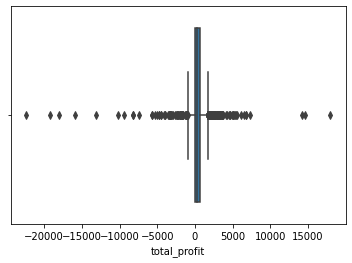

In [26]:
sns.boxplot(x='total_profit' , data= profits)
#plt.xlim(-3000,3000)

(-3000.0, 3000.0)

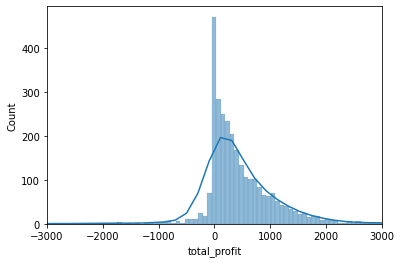

In [27]:
sns.histplot(profits['total_profit'], bins= 500, kde= True)
plt.xlim(-3000,3000)

#### Total profits for Olist

In [28]:
# total revenue from monthly fees
monthly = profits['monthly_fees'].sum()
monthly

1534480.0

Total revenue from monthly fees : **1,534,480 BRL**

In [29]:
# total revenue from 10 % cut
cut = profits['ten_percent_cut'].sum()
cut

1356255.7

Total revenue from sales : **1,356,255 BRL**

In [30]:
# total costs from reviews
cost = profits['total_review_cost'].sum()
cost

1669530

Total costs from negative reviews: **- 1,669,530 BRL**

In [31]:
# total profits
total = monthly + cut - cost - 500_000
total 

721205.7000000002

Revenue:    **2,890,735 BRL**

Cost:     **- 1,669,530 BRL**

IT costs: **- 500,000 BRL**
_____________________________

Profit:     **721,205 BRL**

### Total volume of orders

In [32]:
order_volume = data[['seller_id', 'n_orders']].copy()
order_volume.head()

,seller_id,n_orders
0,3442f8959a84dea7ee197c632cb2df15,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,40
2,ce3ad9de960102d0677a81f5d0bb7b2d,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1
4,51a04a8a6bdcb23deccc82b0b80742cf,1


In [33]:
number_of_orders = order_volume['n_orders'].sum()
print(f'Total number of orders : {number_of_orders}')

Total number of orders : 99844


Total number of orders : **99844**

In [34]:
order_volume['share_of_orders'] = order_volume.n_orders / number_of_orders
order_volume.describe()

,n_orders,share_of_orders
count,2970.000000,2970.000000
mean,33.617508,0.000337
std,107.133714,0.001073
min,1.000000,0.000010
25%,2.000000,0.000020
50%,7.000000,0.000070
75%,23.000000,0.000230
max,1854.000000,0.018569


### IT costs

#### Data overview

In [35]:
# whole dataframe with all important values sorted by the least profitable sellers
overview = bad_reviews[['seller_id','n_orders', 'orders_with_one_stars', 'orders_with_two_stars', 'orders_with_three_stars']].merge(profits, on= 'seller_id')
overview.sort_values(by='total_profit', ignore_index= True).head(10)

,seller_id,n_orders,orders_with_one_stars,orders_with_two_stars,orders_with_three_stars,active_time,monthly_fees,ten_percent_cut,total_revenue,total_review_cost,total_profit
0,6560211a19b47992c3666cc44a7e94c0,1854,238,91,198,19.0,1520.0,12330.48,13850.48,36270,-22419.52
1,4a3ca9315b744ce9f8e9374361493884,1806,269,91,236,20.0,1600.0,20047.29,21647.29,40890,-19242.71
2,cc419e0650a3c5ba77189a1882b7556a,1706,205,58,165,19.0,1520.0,10428.84,11948.84,30000,-18051.16
3,ea8482cd71df3c1969d7b9473ff13abc,1146,134,47,124,13.0,1040.0,3717.75,4757.75,20710,-15952.25
4,8b321bb669392f5163d04c59e235e066,943,112,30,73,10.0,800.0,1753.57,2553.57,15620,-13066.43
5,1f50f920176fa81dab994f9023523100,1404,160,43,103,17.0,1360.0,10693.92,12053.92,22270,-10216.08
6,d2374cbcbb3ca4ab1086534108cc3ab7,524,84,31,78,19.0,1520.0,2122.39,3642.39,13070,-9427.61
7,cca3071e3e9bb7d12640c9fbe2301306,712,112,41,81,23.0,1840.0,6400.99,8240.99,16490,-8249.01
8,7c67e1448b00f6e969d365cea6b010ab,982,198,57,147,19.0,1520.0,18792.39,20312.39,28530,-8217.61
9,1835b56ce799e6a4dc4eddc053f04066,423,90,17,47,12.0,960.0,3334.42,4294.42,11730,-7435.58


#### calculating the IT costs

In [36]:
# total order volume
order_volume = overview['n_orders'].sum()

In [37]:
# IT costs now: 500 000 BRL, scales with square root of number of orders
scaling_factor = 500_000 / np.sqrt(order_volume)

In [38]:
# total profit after IT costs
profit = round(overview['total_profit'].sum() - np.sqrt(order_volume)*scaling_factor , 2)
profit

721205.7

In [39]:
# put those steps in  a function 
def calculate_total_profit(df):
    '''calculates the total profit including the IT costs for a given dataframe'''
    orders = df['n_orders'].sum()
    
    profit = round(df['total_profit'].sum() - scaling_factor*np.sqrt(orders) , 2)
    
    return profit

### How does the profit change when we drop the least profitable sellers?

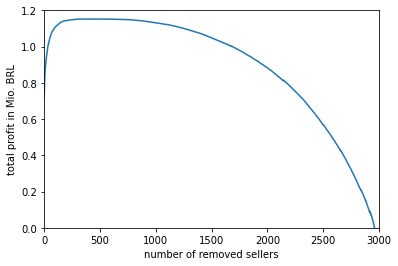

In [40]:
# count the romoved sellers
sellers_removed = []

# save the total profit after removing the sellers
profit_list = []

df = overview.sort_values(by='total_profit', ignore_index= True).copy()

for i in range(len(df)):
    profit_list.append(calculate_total_profit(df[i:]) / 1_000_000)
    sellers_removed.append(i)

sns.lineplot(x = sellers_removed, y = profit_list)
plt.xlabel('number of removed sellers')
plt.ylabel('total profit in Mio. BRL')
plt.xlim(0,3000)
plt.ylim(0,1.2)
plt.show()

#### Maximum profit

In [41]:
max_profit = max(profit_list)
seller_cut = profit_list.index(max_profit)
max_profit, seller_cut

(1.1521876100000001, 483)

In [42]:
num_orders = df['n_orders'][483:].sum()
num_orders

59718

By removing the  **483** least profitable sellers we can increase our profits
from **0,72 Mio BRL** to **1,15 Mio BRL**

In [43]:
f= pd.DataFrame.from_dict({'before': [0.72] , 'after': [1.15]})
f

,before,after
0,0.72,1.15


# Presentation

## Our goal

We want to find a way to maximize our profit margin by cutting down on costs due 
to our sellers. 

Main components of that costs: 
- loss in revenue due to negative buyer experience (reviews)
- IT costs for handling the order volume

## Key values

2,970 sellers with a total of 99,844 orders

___
- Revenue:    **2,890,735 BRL**

- Cost:     **- 1,669,530 BRL**

- IT costs: **- 500,000 BRL**
___

Profit:     **721,205 BRL**

## Strategy 

Found the least profitable sellers based on negative reviews

In [188]:
overview[['total_revenue', 'total_review_cost', 'total_profit']].sort_values(by='total_profit', ignore_index= True).head(10)

,total_revenue,total_review_cost,total_profit
0,13850.48,36270,-22419.52
1,21647.29,40890,-19242.71
2,11948.84,30000,-18051.16
3,4757.75,20710,-15952.25
4,2553.57,15620,-13066.43
5,12053.92,22270,-10216.08
6,3642.39,13070,-9427.61
7,8240.99,16490,-8249.01
8,20312.39,28530,-8217.61
9,4294.42,11730,-7435.58


change of profit by removing underperforming sellers

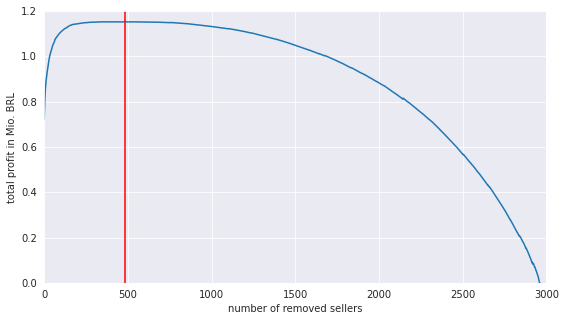

In [250]:
plt.figure(figsize=(9,5))
sns.set_style("darkgrid")
sns.lineplot(x = sellers_removed, y = profit_list)
plt.axvline(483, 0, 1, color= 'red')
plt.xlabel('number of removed sellers')
plt.ylabel('total profit in Mio. BRL')
plt.xlim(0,3000)
plt.ylim(0,1.2)
plt.show()

By removing sellers we cut down on user related costs
while losing order volume and therefore increasing IT costs.

## Result

~~2,970 sellers with a total of 99,844 orders~~

2,487 sellers with a total of 59,718 orders

We can increase our profit by a margin of **50 %**

from **0.72 Mio BRL** to **1.15 Mio BRL**

<function matplotlib.pyplot.show(close=None, block=None)>

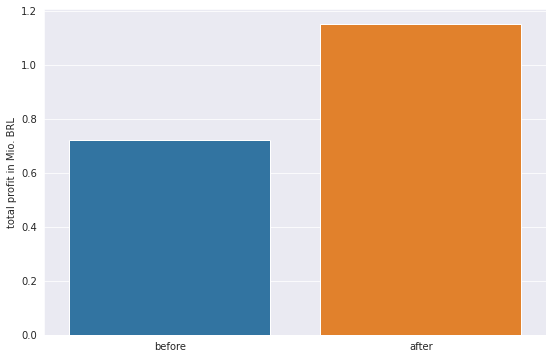

In [268]:
plt.figure(figsize=(9,6))
sns.barplot(data=f)
plt.ylabel('total profit in Mio. BRL')
plt.show